# Vineyard
Experimenting with weighted vineyard distance formulations. Longer line length -> consistent feature -> lower D. Low distance to the diagonal -> unimportant -> lower distance.

In [1]:
import sklearn
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go


/var/folders/fg/n7d57ft153bf46npr6w6jjxr0000gn/T/ipykernel_77967/3356440145.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import gudhi
import gudhi.wasserstein
import gudhi.hera
import ot

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [4]:
X = X.reshape((X.shape[0], 28, 28))

In [5]:
f, g = X[[np.where(y == x)[0][0] for x in "69"]]

In [40]:
g = np.ones_like(f)
for i in range(g.shape[0]):
    for j in range(g.shape[1]):
        g[i][j] = f[i][j-2] if i-1 >= 0 else 0

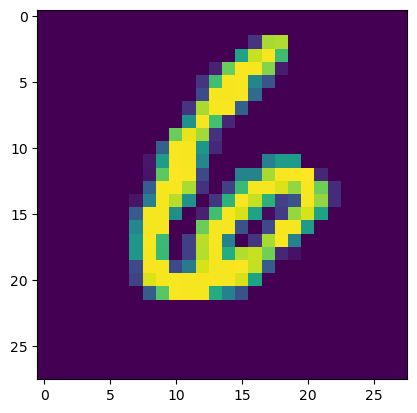

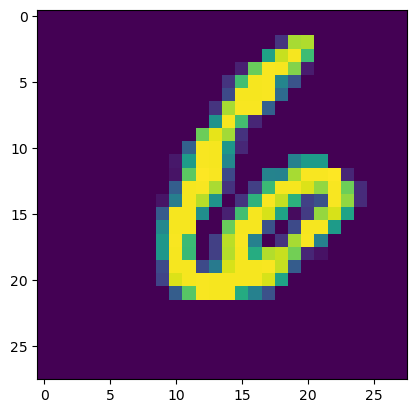

In [41]:
plt.imshow(f)
plt.show()
plt.imshow(g)

In [42]:
ts = np.linspace(0, 1, 100)
hs = np.array([t*f+(1-t)*g for t in ts])

In [43]:
def persistence(array, dimension=None):
  height, width = array.shape
  cubeComplex = gudhi.CubicalComplex(
      dimensions = [width,height],
      top_dimensional_cells = 255 - array.flatten()
  )
 
  if dimension == None:
    persistence = cubeComplex.persistence()
  else:
    cubeComplex.compute_persistence()
    persistence = cubeComplex.persistence_intervals_in_dimension(dimension)
    
  return persistence

In [44]:
PD0 = [persistence(h, dimension=1) for h in hs]

In [45]:
vines = [[0, None, [x,]] for x in range(len(PD0[0]))]
ends = {x:x for x in range(len(PD0[0]))}

for i in range(1, len(ts)):
    dist, match = gudhi.hera.wasserstein_distance(PD0[i-1], PD0[i], matching=True)

    baby = []
    # print("IIII", i)

    new_ends = {k:ends[k] for k in ends}
    for j, (x, y) in enumerate(match):
        # print(x,y)
        if x == -1:
            baby.append(j)
        elif y == -1: # end vines
            vines[ends[x]][1] = i
            vines[ends[x]][2].append(-1)
            # print(f"end {x} -> -1")
        else: # update vines
            vines[ends[x]][2].append(y)
            new_ends[y] = ends[x]
            # print(f"join {x} -> {y} (ind {ends[x]})")
    
    # new vines
    for j in baby:
        x, y = match[j]
        new_ends[y] = len(vines)
        vines.append([i, None, [y,]])
        # print(f"new {y} -> *")

    for k in [l for l in ends]: 
        if k >= len(PD0[i]):
            del new_ends[k]

    ends = new_ends
            
    # print(ends)
    # print(vines)

In [46]:
poss = vines

for i,_ in enumerate(vines):
    # print("II", i, vines[i])
    # print(i, vines[i][2], PD0[0][])
    repl = []
    for j,x in enumerate(vines[i][2]):
        if x == -1:
            # print(PD0[vines[i][0]+j-1][vines[i][2][j-1]], "xx")
            repl.append(np.mean(PD0[vines[i][0]+j-1][vines[i][2][j-1]])*np.ones((2,))) # proj prev
        else:
            repl.append(PD0[vines[i][0]+j][x])

    poss[i][2] = np.array(repl)


In [47]:
res = [[[ts[p[0]+np.arange(len(p[2]))][i], *x] for i,x in enumerate(p[2])] for p in poss]

In [48]:
mx = np.max([np.max(p[2]) for p in poss if np.inf not in p[2]])

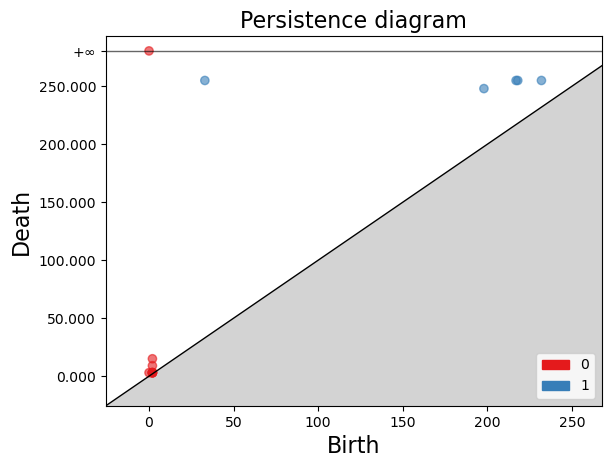

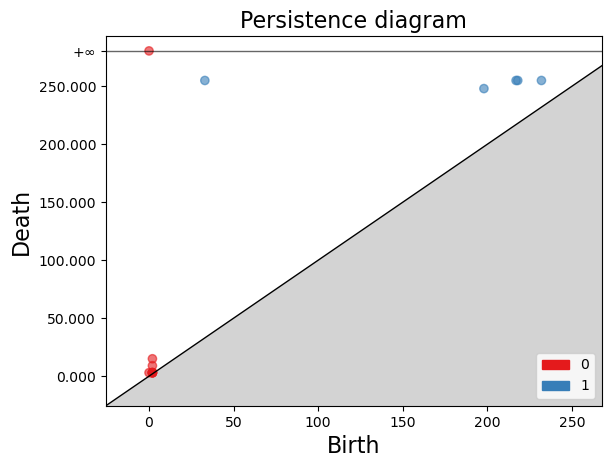

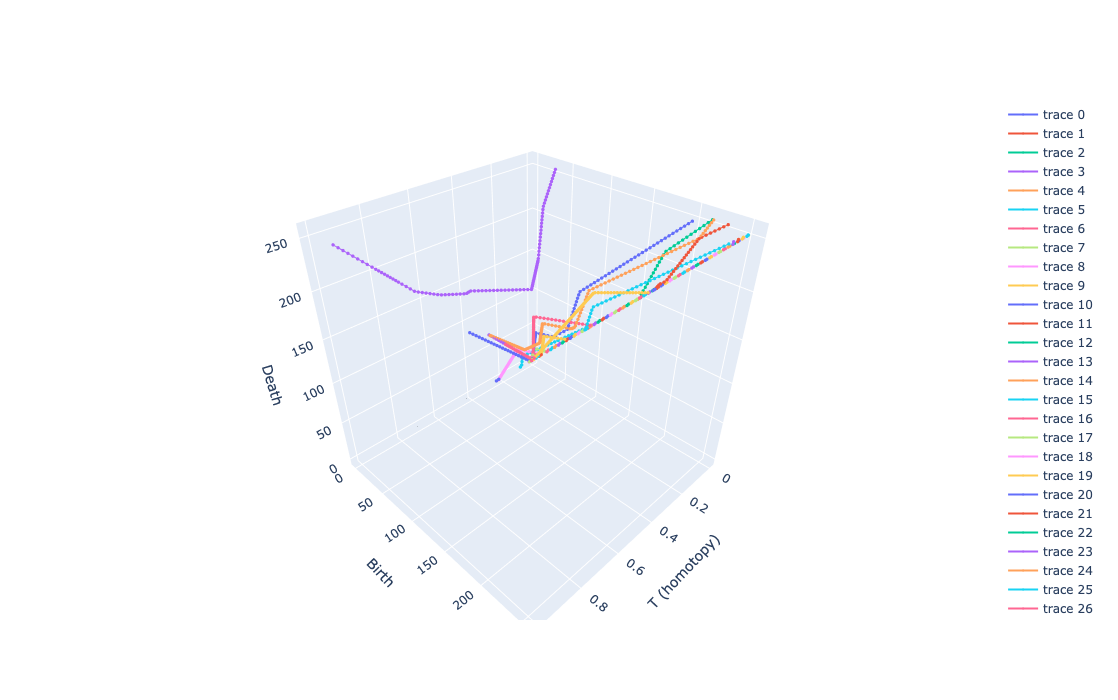

In [49]:
gudhi.plot_persistence_diagram(persistence(hs[len(ts)-1]))
plt.show()
gudhi.plot_persistence_diagram(persistence(hs[0]))
plt.show()

gos = []

for vine in res:
    vine = np.array(vine)
    # print(vine)
    gos.append(go.Scatter3d(x=vine[:,0], y=vine[:,1], z=vine[:,2], marker=dict(
        size=2,
    ),
    line=dict(
        width=2
    )))

xs = np.linspace(0, mx, 10)
zs = np.linspace(0, 1, 10)
xss, zss = np.meshgrid(xs, zs)
gos.append(go.Surface(x=zss, y=xss, z=xss, colorscale=[[0, '#333'], [1, '#333']], opacity=0.1, showscale=False)) # x - y = 0: diag plane

fig = go.Figure(data=gos)

fig.update_layout(
    width=800,
    height=700,
    scene=dict(
      xaxis_title='T (homotopy)',
      yaxis_title='Birth',
      zaxis_title='Death'
  )
)

fig.show()

Weighted integration:
$$v_{k}=g\left(\sum \ell(i)dt\right)\cdot \sum_{i=1}^{n}f\left(\Delta(\frac{p_i+p_{i-1}}{2})\right)\ell(i)dt$$
Here $\ell(i)=|p_i-p_{i-1}|$ and $\Delta()$ is the distance of the projection to the diagonal plane $\Delta$. This is for the $k$-th vine. Then,
$$V=\sum v_k$$

In [50]:
def vdist(res, f, g): # diag weight func, length weight func
    V = 0
    for vine in res:
        vine = np.array(vine)
    
        v, L = 0, 0
        for i in range(1, len(vine)):
            l = np.linalg.norm(vine[i][1:]-vine[i-1][1:])
            dt = vine[i][0] - vine[i-1][0]
    
            mid = np.mean([vine[i][1:],vine[i-1][1:]], axis=0)
            proj = np.mean(mid)*np.ones(2,)
            D = np.linalg.norm(proj-mid)
            
            v += f(D)*l*dt
            L += l*dt
    
        v *= g(L)
        V += v

    return V

In [51]:
Ds, Ls = [], []
def fD(D):
    Ds.append(D)
    return 1
    return D/100 # increases as D increases

def fL(L):
    Ls.append(L)
    return 1
    return np.exp(-L/2) # decreases as L increase: Longer line length -> consistent feature -> lower D

vdist(res, fD, fL)

14.862441124581709